<a href="https://colab.research.google.com/github/19980216wyh/BDML/blob/main/IWM_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Backtesting an ML strategy with Backtrader

## Imports & Settings

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#!pip install backtrader
!pip install git+https://github.com/mementum/backtrader
!pip install git+https://github.com/quantopian/pyfolio
!pip install yfinance
!pip install --upgrade tables
%matplotlib inline

from pathlib import Path
import csv
from time import time
import datetime
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns

import backtrader as bt
from backtrader.feeds import PandasData

import pyfolio as pf

import bs4 as bs
import requests
import yfinance as yf
import datetime
from datetime import date

  Cloning https://github.com/mementum/backtrader to /tmp/pip-req-build-nmmr5v8f
  Running command git clone -q https://github.com/mementum/backtrader /tmp/pip-req-build-nmmr5v8f
  Created wheel for backtrader: filename=backtrader-1.9.76.123-cp37-none-any.whl size=418998 sha256=c0f9065fbb0403204f57373c300655dd649959a57955d3bff2f68fcac04fcaa6
  Stored in directory: /tmp/pip-ephem-wheel-cache-hm7q3842/wheels/17/a4/ba/cd069b1958f4e8a0317b6e70ce7eb1af4e5e5117f8a2cbc007
Successfully built backtrader
  Cloning https://github.com/quantopian/pyfolio to /tmp/pip-req-build-pgcsnxkm
  Running command git clone -q https://github.com/quantopian/pyfolio /tmp/pip-req-build-pgcsnxkm
     |████████████████████████████████| 61kB 4.1MB/s 
  Created wheel for pyfolio: filename=pyfolio-0.9.2+75.g4b901f6-cp37-none-any.whl size=75776 sha256=491d2f8916d1c499d61b3dac6bf38b170ccaa8071fe288767a0eaa9f60b35b66
  Stored in directory: /tmp/pip-ephem-wheel-cache-cs0sllc9/wheels/62/7d/a7/3e462442ba7d63c35414176627c8863

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


project_path = Path('/content/drive/MyDrive/ahfs/project') 
if not project_path.exists():
    project_path.mkdir()

Mounted at /content/drive


In [ ]:
pd.set_option('display.expand_frame_repr', False)
np.random.seed(42)
sns.set_style('darkgrid')
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 12]
plt.rcParams.update({'font.size': 12}) 

In [ ]:
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return f'{h:>02.0f}:{m:>02.0f}:{s:>02.0f}'

## Backtrader Setup

### Custom Commission Scheme

In [ ]:
class FixedCommisionScheme(bt.CommInfoBase):
    """
    Simple fixed commission scheme for demo
    """
    params = (
        ('commission', .02),
        ('stocklike', True),
        ('commtype', bt.CommInfoBase.COMM_FIXED),
    )

    def _getcommission(self, size, price, pseudoexec):
        return abs(size) * self.p.commission

### Strategy

In [ ]:
# assignment 2 -- This is how you decide to go short using a simple moving average
# You can change the fast and slow moving averages here 

class SmaCrossLong(bt.Strategy):
    # list of parameters which are configurable for the strategy
    params = dict(
        pfast=21,  # period for the fast moving average
        pslow=55   # period for the slow moving average
    )
    def __init__(self):
        self.inds = dict()
        for i, d in enumerate(self.datas):
            self.inds[d] = dict()
            self.inds[d]['sma1'] = bt.ind.SMA(d.close, period=self.p.pfast)  # Short-term moving average
            self.inds[d]['sma2'] = bt.ind.SMA(d.close, period=self.p.pslow)  # Long-term moving average
            self.inds[d]['cross'] = bt.ind.CrossOver(self.inds[d]['sma1'], self.inds[d]['sma2'], plot = False)  # Cross letter

    def next(self):
        for i, d in enumerate(self.datas):
            dt, dn = self.datetime.date(), d._name           # Get time and stock code
            pos = self.getposition(d).size
            if not pos:                                      # Not in the market, you can buy
                if self.inds[d]['cross'] > 0:                # If the golden fork
                    self.buy(data = d, size = None) # Buy buy buy
            elif self.inds[d]['cross'] < 0:                  # In the field, and die fork
                self.close(data = d)                         # Selling

In [ ]:
# assignment 2 -- This is how you decide to go short using a simple moving average
# You can change the fast and slow moving averages here 

class SmaCrossShort(bt.Strategy):
    # list of parameters which are configurable for the strategy
    params = dict(
        pfast=55,  # period for the fast moving average
        pslow=105   # period for the slow moving average
    )
    def __init__(self):
        self.inds = dict()
        for i, d in enumerate(self.datas):
            self.inds[d] = dict()
            self.inds[d]['sma4'] = bt.ind.SMA(d.close, period=self.p.pfast)  # Short-term moving average
            self.inds[d]['sma3'] = bt.ind.SMA(d.close, period=self.p.pslow)  # Long-term moving average
            self.inds[d]['cross'] = bt.ind.CrossOver(self.inds[d]['sma3'], self.inds[d]['sma4'], plot = False)  # Cross letter

    def next(self):
        for i, d in enumerate(self.datas):
            dt, dn = self.datetime.date(), d._name           # Get time and stock code
            pos = self.getposition(d).size
            if not pos:                                      # Not in the market, you can buy
                if self.inds[d]['cross'] > 0:                # If the golden fork
                    self.buy(data = d, size = None) # Buy buy buy
            elif self.inds[d]['cross'] < 0:                  # In the field, and die fork
                self.close(data = d)                         # Selling



### Create and Configure Cerebro Instance

In [ ]:
cerebro = bt.Cerebro()  # create a "Cerebro" instance

cash = 10000
comminfo = FixedCommisionScheme()
cerebro.broker.addcommissioninfo(comminfo)  # set up commisions
cerebro.broker.setcash(cash)

### Add input data

In [ ]:
# Assignment 2 -- Here is where you add/choose tickers - data comes from yahoo finance

### ONLY 1 Security at a Time ###

tickers = ["VBR","IWM"]
for ticker in tickers:
    data = bt.feeds.PandasData(dataname=yf.download(ticker, '2015-07-06', '2021-07-01', auto_adjust=True))
    cerebro.adddata(data,name=ticker)
    


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
data

### Run Strategy Backtest

In [ ]:
# Assignment 2 -- Run strategy. Look at changing n_positon and min_positions as you add tickers
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
cerebro.addsizer(bt.sizers.PercentSizer, percents = 100/len(tickers))

# add long strategy
cerebro.addstrategy(SmaCrossLong)

## focus on long positions but play with short if you are curious ##
## by nuncommenting the next line                                 ##
cerebro.addstrategy(SmaCrossShort)

start = time()
results = cerebro.run()
ending_value = cerebro.broker.getvalue()
duration = time() - start

print(f'Final Portfolio Value: {ending_value:,.2f}')
print(f'Duration: {format_time(duration)}')

Final Portfolio Value: 17,833.07
Duration: 00:00:02


### Plot result

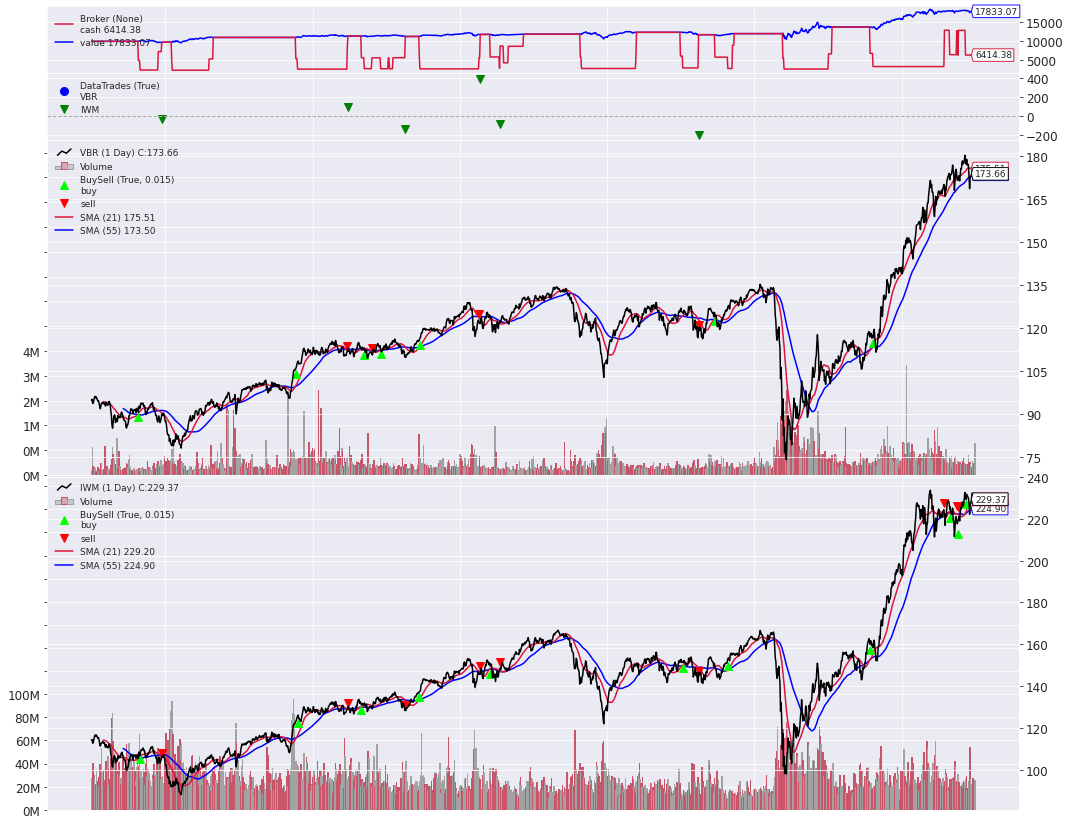

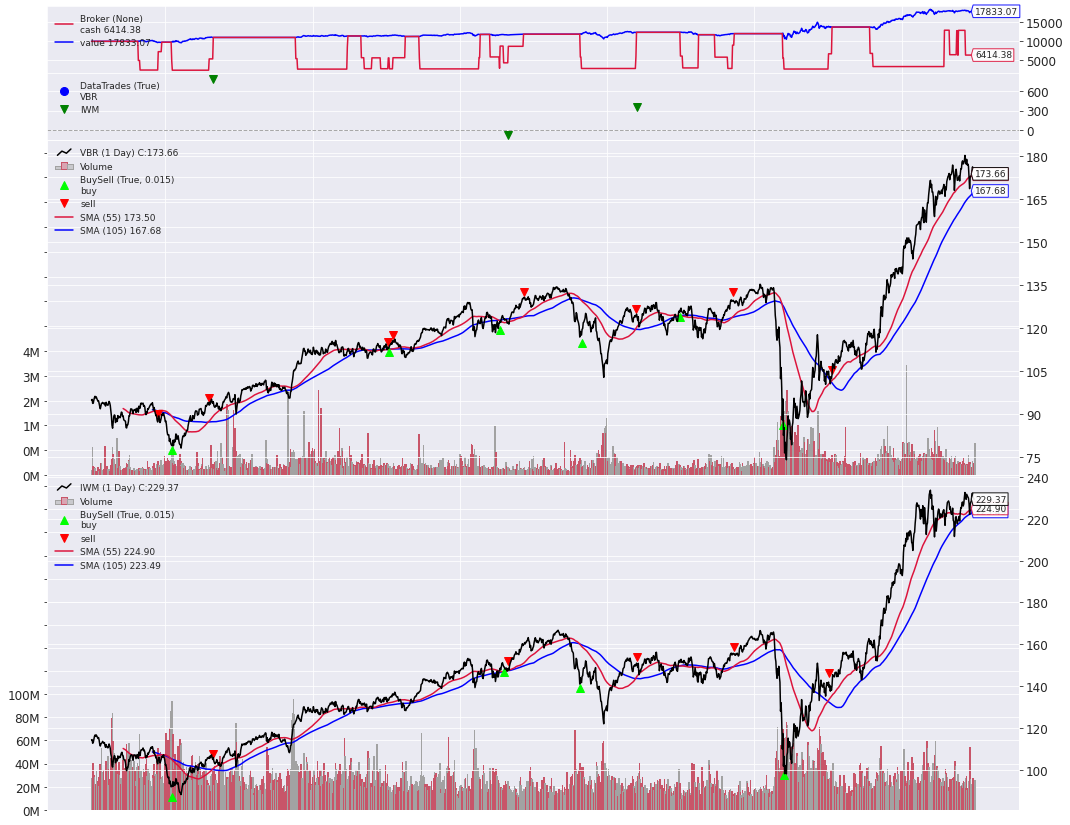

[[<Figure size 1080x864 with 6 Axes>], [<Figure size 1080x864 with 6 Axes>]]

In [ ]:

cerebro.plot(iplot = False)

Disabled because large number of datafeeds all plot separately.

### Get `pyfolio` inputs

In [ ]:
# prepare pyfolio inputs
pyfolio_analyzer = results[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()

returns.to_hdf('backtrader.h5', 'returns')
positions.to_hdf('backtrader.h5', 'positions')
transactions.to_hdf('backtrader.h5', 'transactions/')
gross_lev.to_hdf('backtrader.h5', 'gross_lev')

## Run pyfolio analysis

In [ ]:
returns = pd.read_hdf('backtrader.h5', 'returns')
positions = pd.read_hdf('backtrader.h5', 'positions')
transactions = pd.read_hdf('backtrader.h5', 'transactions/')
gross_lev = pd.read_hdf('backtrader.h5', 'gross_lev')

In [ ]:
benchmark = web.DataReader('SP500', 'fred', start = date (2017, 7, 1), end = date (2021, 5, 31)).squeeze()
benchmark = benchmark.pct_change().tz_localize('UTC')

In [ ]:
benchmark=benchmark.dropna()

In [ ]:
daily_tx = transactions.groupby(level=0)
longs = daily_tx.value.apply(lambda x: x.where(x>0).sum())
shorts = daily_tx.value.apply(lambda x: x.where(x<0).sum())

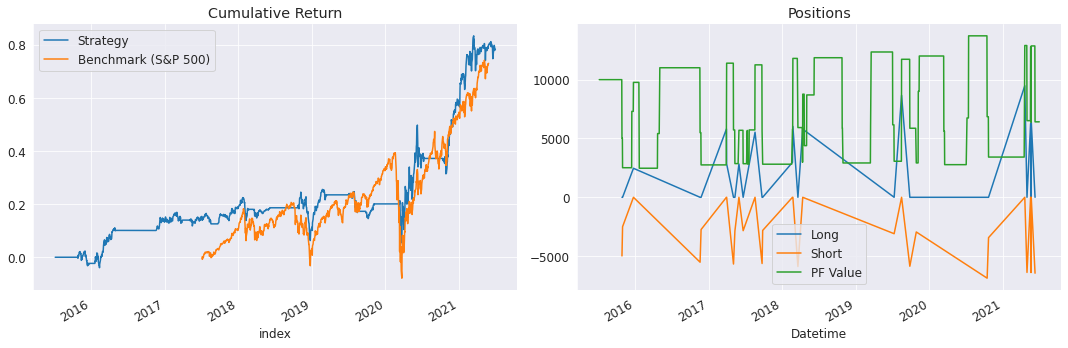

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

df = returns.to_frame('Strategy').join(benchmark.to_frame('Benchmark (S&P 500)'))
df.add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return')

longs.plot(label='Long',ax=axes[1], title='Positions')
shorts.plot(ax=axes[1], label='Short')
positions.cash.plot(ax=axes[1], label='PF Value')
axes[1].legend()
sns.despine()
fig.tight_layout();

Start date,2015-07-06
End date,2021-06-30
Total months,71
,Backtest
Annual return,10.142%
Cumulative returns,78.331%
Annual volatility,13.462%
Sharpe ratio,0.79
Calmar ratio,0.63
Stability,0.72
Max drawdown,-16.036%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,16.04,2019-02-22,2020-03-23,2020-04-09,295
1,14.65,2018-11-07,2018-12-24,2019-02-19,75
2,12.27,2020-06-08,2020-10-28,2020-11-24,122
3,9.07,2020-04-29,2020-05-13,2020-05-26,20
4,7.17,2021-03-15,2021-03-24,NaT,NaN


Top 10 long positions of all time,max
IWM,74.36%


Top 10 short positions of all time,max


Top 10 positions of all time,max
IWM,74.36%


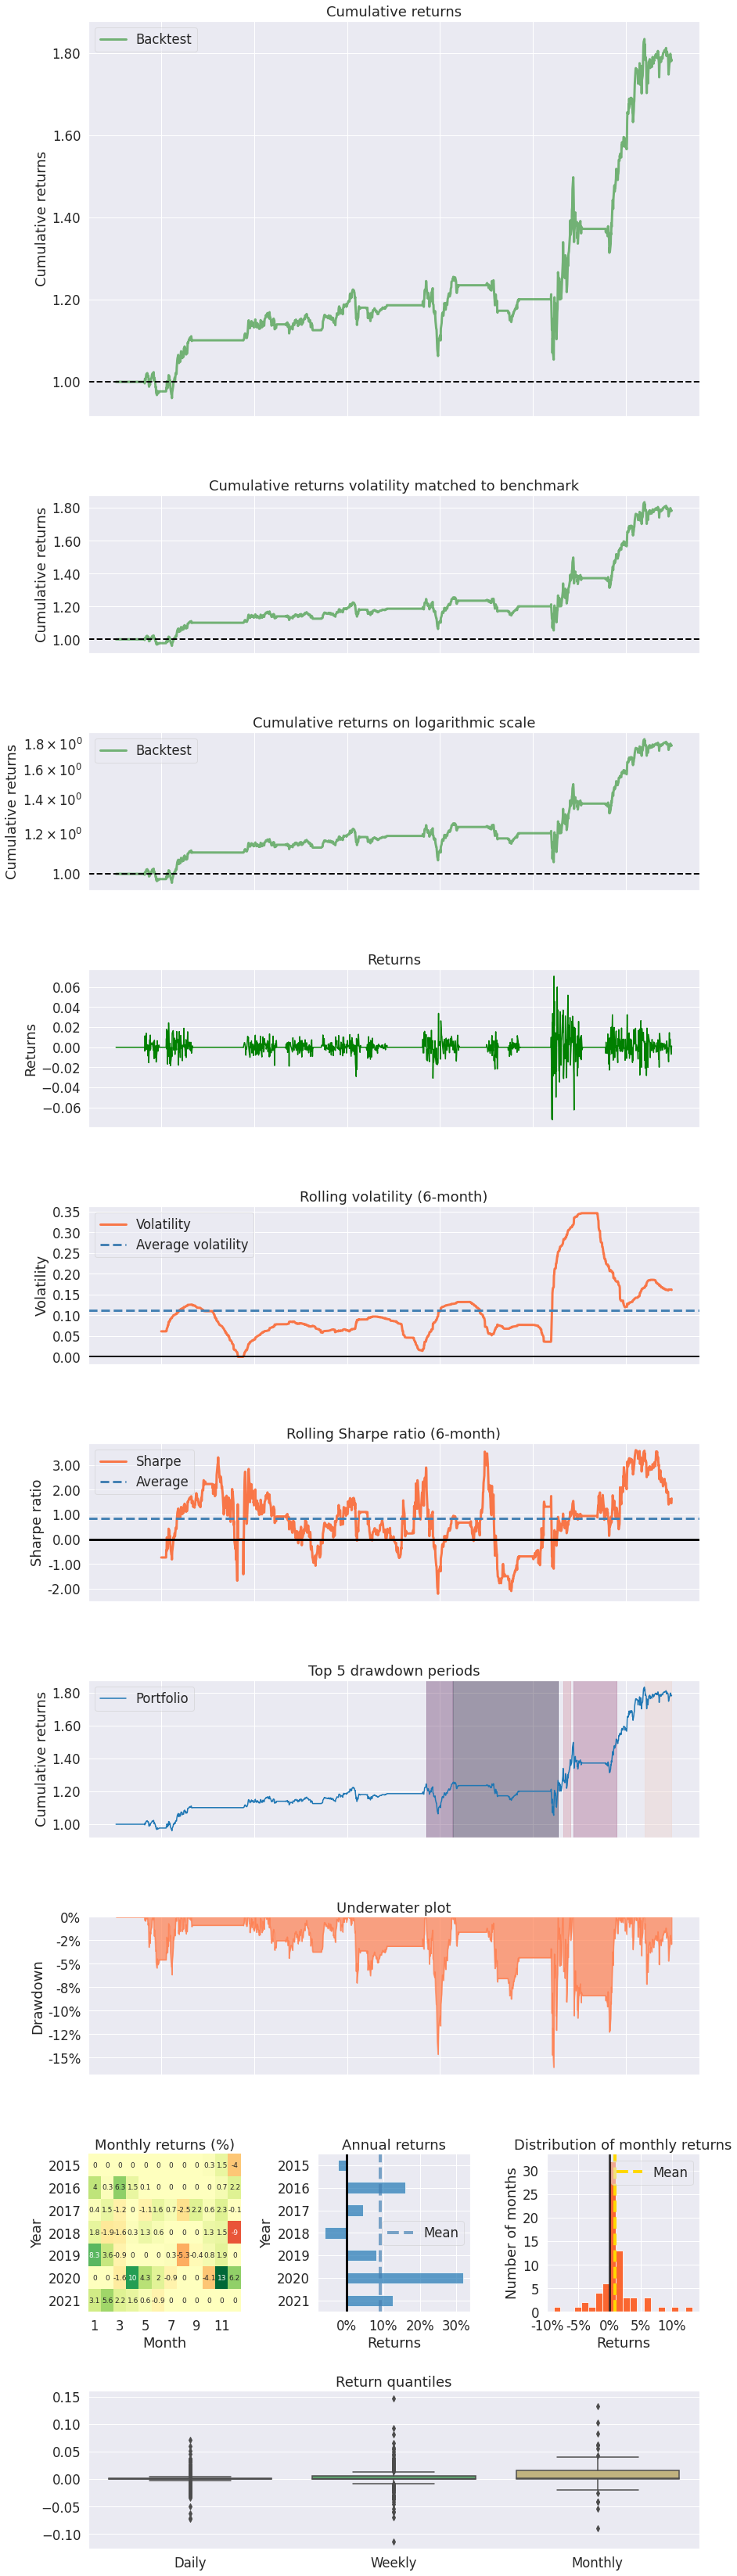

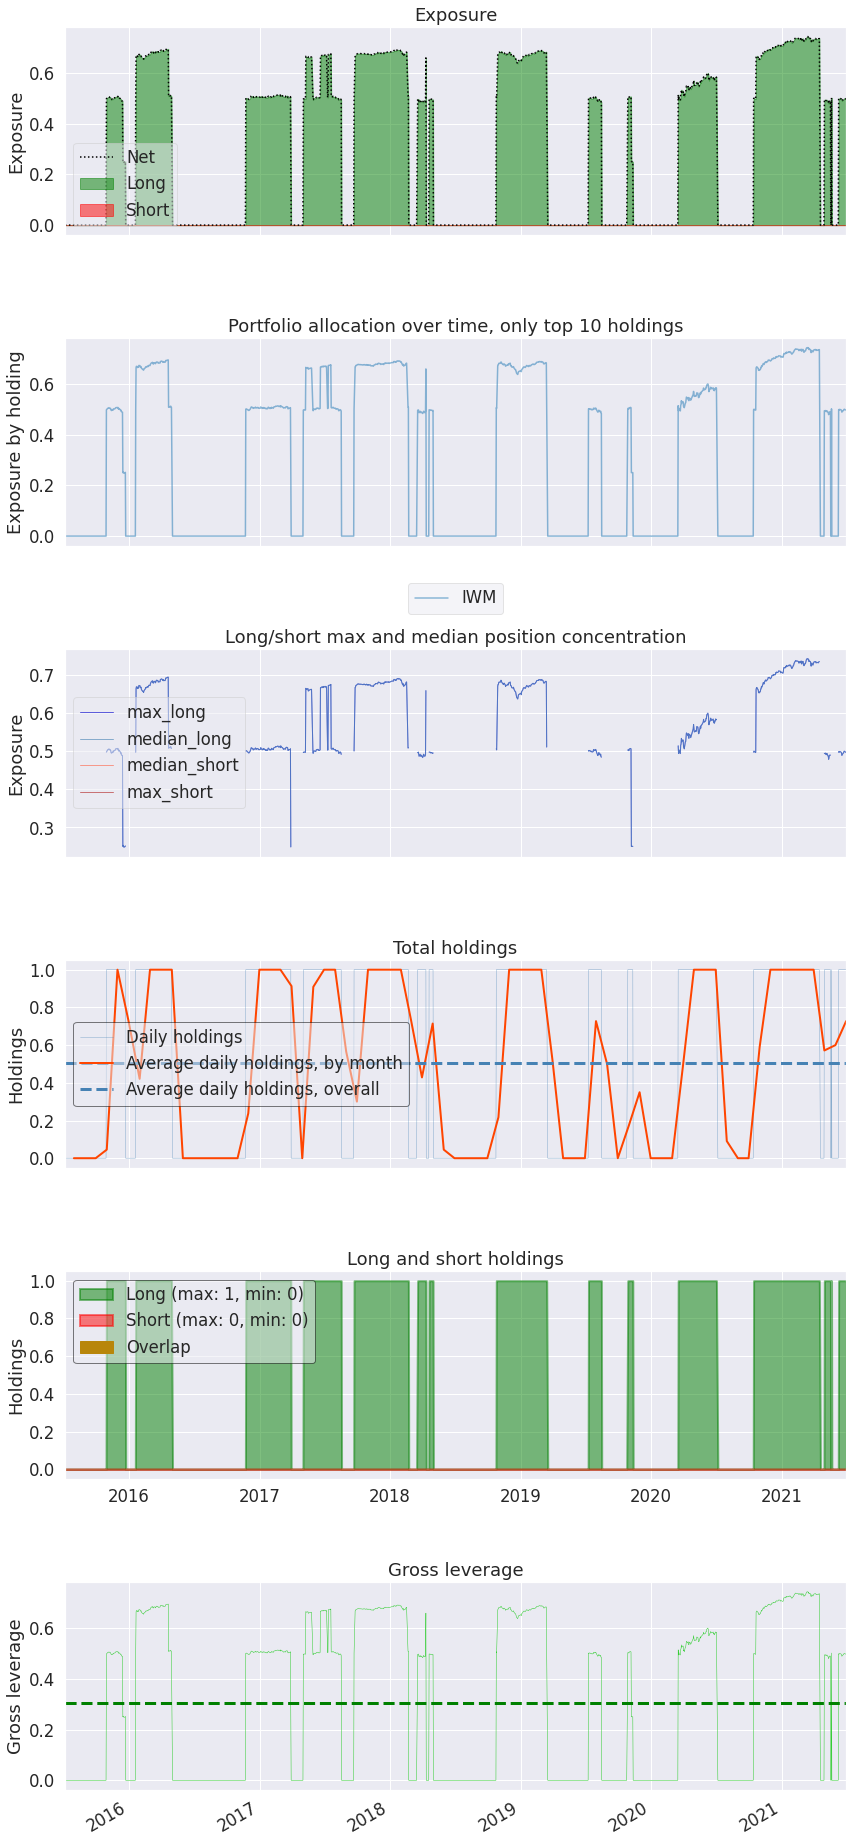

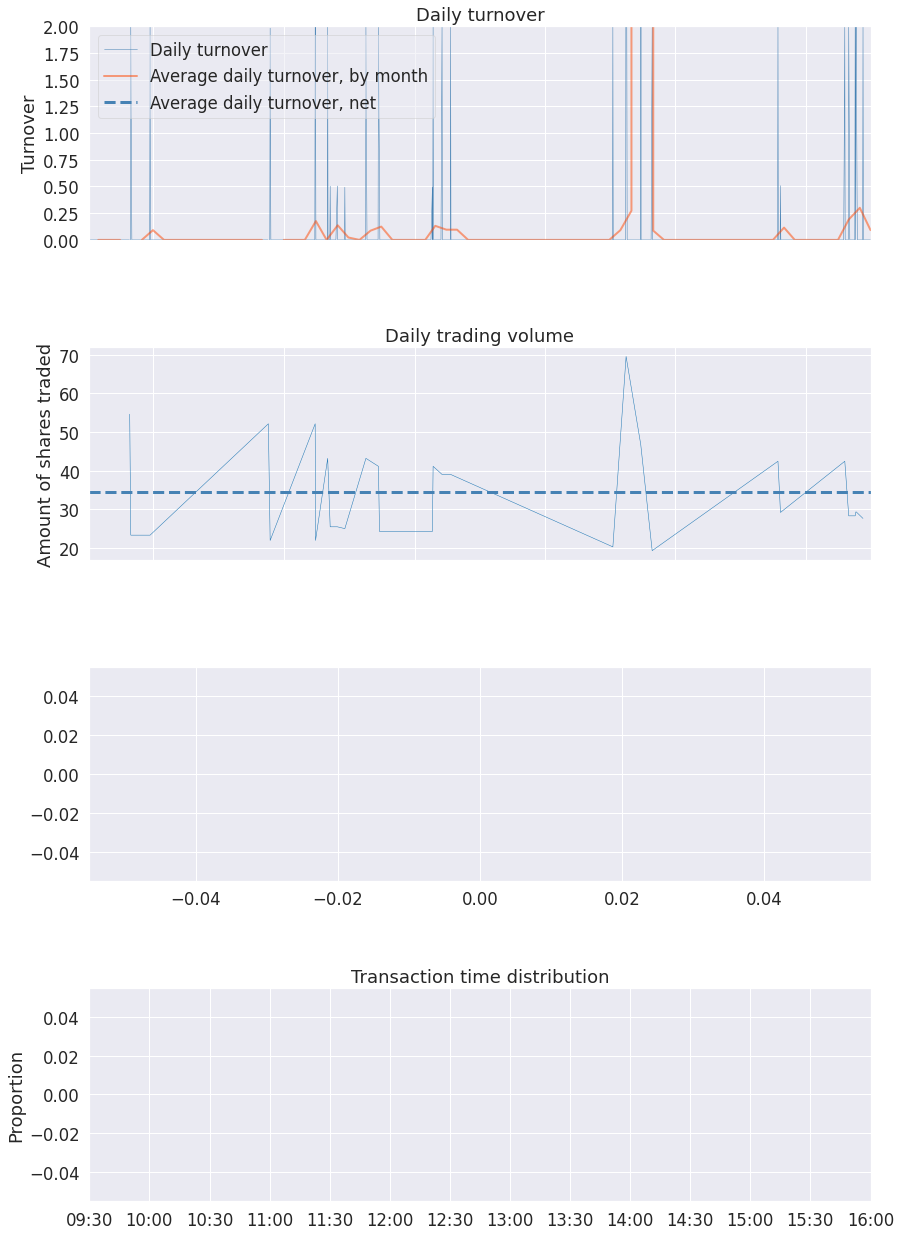

In [ ]:
pf.create_full_tear_sheet(returns,
                          transactions=transactions,
                          positions=positions)

In [ ]:
import os

**Be sure to add .csv to file name**

In [ ]:
filepath = os.path.join(project_path, input("Enter Returns Save filename: "))
returns.to_csv(filepath)

Enter Returns Save filename: aa
